# Importing the data and dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_csv('data/aggregated_df.csv')
# Rename columns by replacing spaces with underscores
df.columns = df.columns.str.replace(' ', '_').str.lower()
print(df.columns)

Index(['person_id', 'drinks', 'fastfood', 'sports', 'food_23_before_sleep',
       'medication', 'date_created', 'woke_up_by_(smart)_alarm',
       'woke_up_by_external_factors', 'slept_again_after_alarm', 'smart_alarm',
       'date', 'time_of_awakening', 'state_before_awakening',
       'number_of_measurements', 'average_heart_rate',
       'average_lowest_three_obs', 'average_first_ten_min',
       'average_first_thirty_min'],
      dtype='object')


# Train nested OLS models

In [3]:
# Function to add model results to a list
def add_model_to_results(data, predictors, outcome, results_list, models):
    formula = "{} ~ {}".format(outcome, ' + '.join(predictors))
    model = smf.ols(formula, data=data).fit()
    models.append(model)
    model_summary = {
        'Model': ' + '.join(predictors),
        'AIC': model.aic,
        'BIC': model.bic,
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'Coefficients': model.params.to_dict()
    }
    results_list.append(model_summary)

# Function to add predictors based on correlation
def add_predictors_by_correlation(df, predictors, outcome, models):
    correlation_with_outcome = df[predictors].corrwith(df[outcome]).abs().sort_values(ascending=False)
    included = ['smart_alarm']  # Start with smart_alarm as the base model
    results_list = []
    add_model_to_results(df, included, outcome, results_list, models)
    for predictor in correlation_with_outcome.index:
        if predictor != 'smart_alarm':  # Avoid re-adding smart_alarm
            included.append(predictor)
            add_model_to_results(df, included, outcome, results_list, models)
    return included, results_list

# Define your predictors and outcome variable
predictors = ['smart_alarm', 'drinks', 'fastfood', 'sports', 'food_23_before_sleep', 'medication']
outcome_variable = 'average_heart_rate'

models = []
# Run the function
selected_predictors, model_summaries = add_predictors_by_correlation(df, predictors, outcome_variable, models)

# Creating DataFrame from the list of model summaries
model_results_df = pd.DataFrame(model_summaries)

# Extracting coefficients into a DataFrame and formatting
coefficients = model_results_df['Coefficients'].apply(pd.Series)
coefficients = coefficients.fillna('')  # Replace NaN with empty strings for readability

# Concatenate the coefficients to the readable DataFrame
model_results_df = pd.concat([model_results_df, coefficients], axis=1).drop('Coefficients', axis=1)

# Display the formatted DataFrame
print(model_results_df)

                                               Model         AIC         BIC  \
0                                        smart_alarm  917.456633  922.875694   
1                           smart_alarm + medication  903.345291  911.473881   
2                  smart_alarm + medication + drinks  902.906215  913.744336   
3  smart_alarm + medication + drinks + food_23_be...  903.898031  917.445682   
4  smart_alarm + medication + drinks + food_23_be...  905.733619  921.990801   
5  smart_alarm + medication + drinks + food_23_be...  907.696555  926.663266   

   R-squared  Adj. R-squared  Intercept  smart_alarm medication    drinks  \
0   0.005023       -0.004106  80.505800    -2.119973                        
1   0.139449        0.123513  77.601451    -2.365530   12.86212             
2   0.158152        0.134549  78.845511    -2.960226  12.536699 -5.582759   
3   0.165764        0.134283  78.044972    -2.705553  12.627629 -6.566816   
4   0.166999        0.127332  77.842043    -2.656851  

# Presenting the results

In [4]:
# Combining the model summaries into one table
summary_table = summary_col(models, 
                                    stars=True, 
                                    model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6'],
                                    info_dict={'R-squared': lambda x: f"{x.rsquared:.2f}",
                                               'Adj. R-squared': lambda x: f"{x.rsquared_adj:.2f}",
                                               'AIC': lambda x: f"{x.aic:.0f}",
                                               'BIC': lambda x: f"{x.bic:.0f}"},
                                    float_format="%0.3f")

# Generating the combined summary table in LaTeX format
summary_table_latex = summary_table.as_latex()
print(summary_table_latex)

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllllll}
\hline
                        & Model 1   & Model 2   & Model 3   & Model 4   & Model 5   & Model 6    \\
\hline
Intercept               & 80.506*** & 77.601*** & 78.846*** & 78.045*** & 77.842*** & 78.088***  \\
                        & (1.899)   & (1.910)   & (2.062)   & (2.217)   & (2.285)   & (2.648)    \\
smart\_alarm            & -2.120    & -2.366    & -2.960    & -2.706    & -2.657    & -2.809     \\
                        & (2.858)   & (2.671)   & (2.682)   & (2.695)   & (2.708)   & (2.840)    \\
medication              &           & 12.862*** & 12.537*** & 12.628*** & 12.683*** & 12.624***  \\
                        &           & (3.131)   & (3.119)   & (3.121)   & (3.136)   & (3.167)    \\
drinks                  &           &           & -5.583    & -6.567*   & -6.734*   & -6.834*    \\
                        &           &           & (3.621)   & (3.757)   & (3.796)   & (3.851)    \\
food\_23\_be

In [5]:
print(models[3].summary())

                            OLS Regression Results                            
Dep. Variable:     average_heart_rate   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     5.266
Date:                Mon, 08 Jan 2024   Prob (F-statistic):           0.000659
Time:                        15:23:41   Log-Likelihood:                -446.95
No. Observations:                 111   AIC:                             903.9
Df Residuals:                     106   BIC:                             917.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               78.0450 

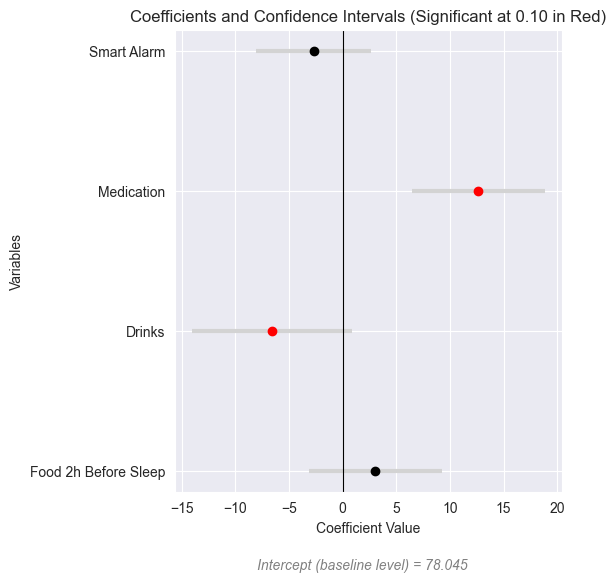

In [6]:
# Custom function with options to reorder variables and change display names
def plot_model_summary_custom(model, variable_order=None, name_mapping=None, significance_level=0.10, figsize=(5, 6)):
    """
    Plots the coefficients and confidence intervals of a regression model.
    Allows reordering of variables and changing of display names.
    Highlights significant predictors at the specified significance level.
    """
    # Extracting coefficients, confidence intervals, p-values, and variable names
    coefficients = model.params.drop('Intercept')
    confidence_intervals = model.conf_int().loc[coefficients.index]
    p_values = model.pvalues.drop('Intercept')

    # Reordering variables if specified
    if variable_order:
        coefficients = coefficients.loc[variable_order]
        confidence_intervals = confidence_intervals.loc[variable_order]
        p_values = p_values.loc[variable_order]

    # Changing variable display names if specified
    variables = coefficients.index
    if name_mapping:
        variables = [name_mapping.get(var, var) for var in variables]

    # Plot
    plt.figure(figsize=figsize)
    for i, var in enumerate(variables):
        original_var = coefficients.index[i]
        color = 'red' if p_values[original_var] < significance_level else 'black'
        plt.errorbar(x=coefficients[original_var], y=i, 
                     xerr=[[coefficients[original_var] - confidence_intervals.loc[original_var][0]], 
                           [confidence_intervals.loc[original_var][1] - coefficients[original_var]]], 
                     fmt='o', color=color, ecolor='lightgray', elinewidth=3, capsize=0)
    plt.axvline(x=0, color='black', linewidth=0.8)
    plt.yticks(ticks=np.arange(len(variables)), labels=variables)
    plt.title('Coefficients and Confidence Intervals (Significant at 0.10 in Red)')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Variables')
    plt.figtext(0.5, -0.02, "Intercept (baseline level) = 78.045", ha="center", fontsize=10, color="gray", fontstyle='italic')
    plt.grid(True)
    plt.show()

variable_order = [
    "food_23_before_sleep",
    "drinks",
    "medication",
    "smart_alarm"
]

name_mapping = {
    "food_23_before_sleep": "Food 2h Before Sleep",
    "drinks": "Drinks",
    "medication": "Medication",
    "smart_alarm": "Smart Alarm"
}

# Plotting with the custom settings
plot_model_summary_custom(models[3], variable_order=variable_order, name_mapping=name_mapping)

# Validating the assumptions

In [7]:
model = models[3]
X = df[variable_order]

NameError: name 'y' is not defined

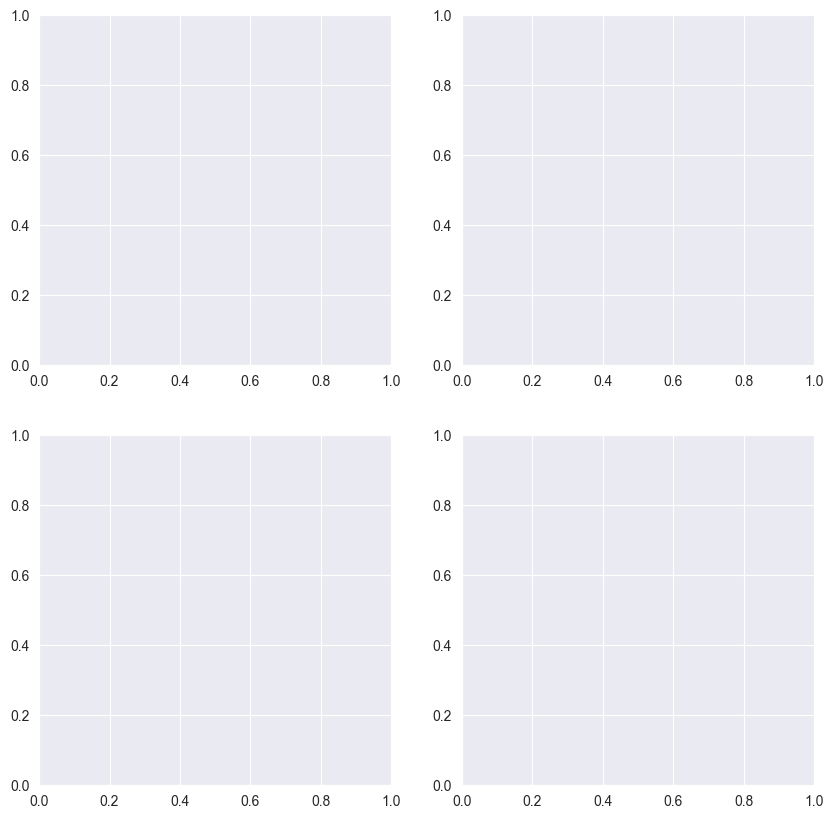

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Assumption 1: Linearity - Observed vs Predicted Values
sns.scatterplot(x=y, y=model.predict(X), ax=axs[0, 0])
axs[0, 0].plot([min(y), max(y)], [min(y), max(y)], color='red', lw=2, linestyle='--')
axs[0, 0].set_xlabel("Observed Values")
axs[0, 0].set_ylabel("Predicted Values")
axs[0, 0].set_title("Observed vs. Predicted Values")

# Assumption 3: Homoscedasticity - Residuals vs Fitted values
sns.residplot(x=model.predict(X), y=model.resid, lowess=True, line_kws={'color': 'red'}, ax=axs[0, 1])
axs[0, 1].set_xlabel("Fitted Values")
axs[0, 1].set_ylabel("Residuals")
axs[0, 1].set_title("Residuals vs. Fitted")

# Assumption 4: Normal Distribution of Errors - Q-Q plot
sm.qqplot(model.resid, line='s', ax=axs[1, 0])
axs[1, 0].set_title("Normal Q-Q plot of Residuals")

# Assumption 7: No Influential Outliers - Cook's Distance
(c, p) = model.get_influence().cooks_distance
axs[1, 1].stem(np.arange(len(c)), c, markerfmt=",")
axs[1, 1].set_title("Cook's Distance")
axs[1, 1].set_xlabel("Observation Index")
axs[1, 1].set_ylabel("Cook's Distance")

plt.tight_layout()
plt.show()


In [ ]:
# Assumption 2: Independence of Errors (Durbin-Watson Test)
# Values of 1.5 to 2.5 are generally considered acceptable
print('Durbin-Watson:', sm.stats.durbin_watson(model.resid))


# Assumption 5: No Multicollinearity
# Variance Inflation Factor (VIF) calculation
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data.to_latex(index=False))

# Robustness Check performing ols with stepwise selection

In [ ]:
def add_model_to_results(data, predictors, outcome, results_list):
    formula = "{} ~ {}".format(outcome, ' + '.join(predictors))
    model = smf.ols(formula, data=data).fit()
    model_summary = {
        'Model': ' + '.join(predictors),
        'AIC': model.aic,
        'BIC': model.bic,
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'Coefficients': model.params.to_dict()
    }
    results_list.append(model_summary)

def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.1):
    included = list(initial_list)
    results_list = []  # List to store model summaries
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            formula = "{} ~ {}".format(y, ' + '.join(included + [new_column]))
            model = ols(formula, data=df).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            add_model_to_results(df, included, y, results_list)
        
        
        # Backward step
        model = ols("{} ~ {}".format(y, ' + '.join(included)), data=df).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            add_model_to_results(df, included, y, results_list)
        
        if not changed:
            break
    return included, results_list

In [ ]:
# Running the stepwise selection
predictors = ['smart_alarm', 'drinks', 'fastfood', 'sports', 'food_23_before_sleep', 'medication']
outcome_variable = 'average_heart_rate'

selected_predictors, model_summaries = stepwise_selection(df[predictors], outcome_variable)

# Creating DataFrame from the list of model summaries
model_results_df = pd.DataFrame(model_summaries)

# Print the results
print(model_results_df)